## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score,f1_score, make_scorer, classification_report, roc_auc_score
from sklearn.dummy import DummyClassifier
import sqlite3
import datetime
import scikitplot as skplt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from gensim.models import Word2Vec
import spacy
import re
from tqdm import tqdm
import os
from wordcloud import WordCloud

from sklearn.externals.joblib import parallel_backend
from sklearn.externals import joblib

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Exploratory Data Analysis

### Read The Data

In [3]:
data = pd.read_csv('../static/data/KickStarter2018.csv')
data.head()

,backers_count,blurb,converted_pledged_amount,created_at,currency,currency_symbol,current_currency,deadline,fx_rate,goal,id,is_starrable,launched_at,name,pledged,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_pledged,usd_type,cat_id,cat_name,cat_parent,cat_parent_id,cat_link,creator_id,creator_name,creater_registered,loc_id,loc_name,loc_state,loc_country,loc_type,loc_url,continent,photo_url,profile_id,project_id,project_url,campaign_length,year,month,day
0,4,Handmade glass trees that make a special Chris...,205,2016-06-03,USD,$,USD,2016-06-21,1.000000,1000.0,1145008426,False,2016-06-04,Glass Christmas Trees & Glass Cross,205.0,glass-christmas-trees-and-glass-cross,https://www.kickstarter.com/discover/categorie...,False,False,failed,2016-06-21,1.000000,205.000000,domestic,347,Glass,crafts,26,http://www.kickstarter.com/discover/categories...,661261267,Mark & Julie Glocke,False,2508897,Turtle Lake,WI,US,Town,https://www.kickstarter.com/discover/places/tu...,North America,https://ksr-ugc.imgix.net/assets/012/621/061/7...,2543897,2543897,https://www.kickstarter.com/projects/coldglass...,17,2016,6,4
1,171,Perfect pair of Socks for any Adventurer! Sock...,6061,2018-10-24,USD,$,USD,2018-11-15,1.000000,2000.0,1687733153,False,2018-10-30,Socks of Speed and Socks of Elvenkind,6061.0,socks-of-speed-and-socks-of-elvenkind,https://www.kickstarter.com/discover/categorie...,True,False,successful,2018-11-15,1.000000,6061.000000,international,34,Tabletop Games,games,12,http://www.kickstarter.com/discover/categories...,497057119,Andy,False,2449378,Menasha,WI,US,Town,https://www.kickstarter.com/discover/places/me...,North America,https://ksr-ugc.imgix.net/assets/023/068/417/2...,3498932,3498932,https://www.kickstarter.com/projects/497057119...,16,2018,10,30
2,9,This is a Series of 6 Books on Blessed Oscar A...,800,2015-06-17,USD,$,USD,2015-08-16,1.000000,4400.0,1608693208,False,2015-07-07,The Complete Homilies of Blessed Oscar Romero:...,800.0,the-complete-homilies-of-blessed-oscar-romero-...,https://www.kickstarter.com/discover/categorie...,False,False,failed,2015-08-16,1.000000,800.000000,domestic,327,Translations,publishing,18,http://www.kickstarter.com/discover/categories...,267701790,Convivium Press,False,2450022,Miami,FL,US,Town,https://www.kickstarter.com/discover/places/mi...,North America,https://ksr-ugc.imgix.net/assets/012/171/280/2...,1965582,1965582,https://www.kickstarter.com/projects/convivium...,40,2015,7,7
3,24,Prodeus makes self employment simple and intui...,1484,2017-05-05,USD,$,USD,2017-06-21,1.000000,50000.0,66308869,False,2017-05-22,Prodeus: The Future of Work & Learning,1484.0,prodeus-social-network-learning-community-micr...,https://www.kickstarter.com/discover/categorie...,False,False,failed,2017-06-21,1.000000,1484.000000,domestic,342,Web,technology,16,http://www.kickstarter.com/discover/categories...,973039847,James Harr,False,12589335,Brooklyn,NY,US,County,https://www.kickstarter.com/discover/places/br...,North America,https://ksr-ugc.imgix.net/assets/016/544/145/e...,2988723,2988723,https://www.kickstarter.com/projects/973039847...,30,2017,5,22
4,62,"Welcome to Dungeon Corp LTD, a Dungeons and Dr...",1066,2018-12-11,EUR,€,USD,2019-02-15,1.133688,700.0,654590050,False,2019-01-11,Dungeon Corp LTD.: The Adventures of Bob and Tim.,941.0,dungeon-corp-ltd-the-adventures-of-bob-and-tim,https://www.kickstarter.com/discover/categorie...,False,True,live,2019-01-11,1.155864,1087.667629,domestic,250,Comic Books,comics,3,http://www.kickstarter.com/discover/categories...,496847178,Eternalverse,False,777341,Vigo,Galicia,ES,Town,https://www.kickstarter.com/discover/places/vi...,Europe,https://ksr-ugc.imgix.net/assets/023/542/956/0...,3533340,3533340,https://www.kickstarter.com/projects/eternalve...,35,2019,1,11


In [4]:
len(np.unique(data['profile_id']))

223394

### Number of rows and columns

In [5]:
print('Number of rows : {}'.format(data.shape[0]))
print('Number of columns : {}'.format(data.shape[1]))

Number of rows : 223394
Number of columns : 47


### Column names

In [6]:
data.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount', 'created_at', 'currency', 'currency_symbol', 'current_currency', 'deadline', 'fx_rate', 'goal', 'id', 'is_starrable', 'launched_at', 'name', 'pledged', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at', 'static_usd_rate', 'usd_pledged', 'usd_type', 'cat_id', 'cat_name', 'cat_parent', 'cat_parent_id', 'cat_link', 'creator_id', 'creator_name', 'creater_registered', 'loc_id', 'loc_name', 'loc_state', 'loc_country', 'loc_type', 'loc_url', 'continent', 'photo_url', 'profile_id', 'project_id', 'project_url', 'campaign_length', 'year', 'month', 'day'], dtype='object')

### Check for Duplicates

In [7]:
print(data.shape[0] - data.drop_duplicates().shape[0])

0


### Explore The Distribution of 'State'

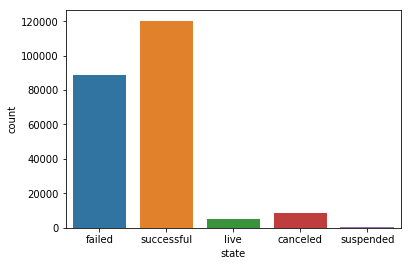

In [8]:
sns.countplot(data['state'])

### Only keeping rows with state as 'successful' or 'failed'

In [9]:
data = data[(data['state']=='failed') | (data['state']=='successful')]
print('Number of rows : {}'.format(data.shape[0]))
print('Number of columns : {}'.format(data.shape[1]))
print('\nDistribution of Class Label:')
print(data['state'].value_counts(normalize=True))

Number of rows : 208994
Number of columns : 47

Distribution of Class Label:
successful    0.57549
failed        0.42451
Name: state, dtype: float64


## Frequently occuring categories

In [10]:
suc_cat = data[data['state']=='successful']['cat_name'].values
freq_suc = Counter(suc_cat)

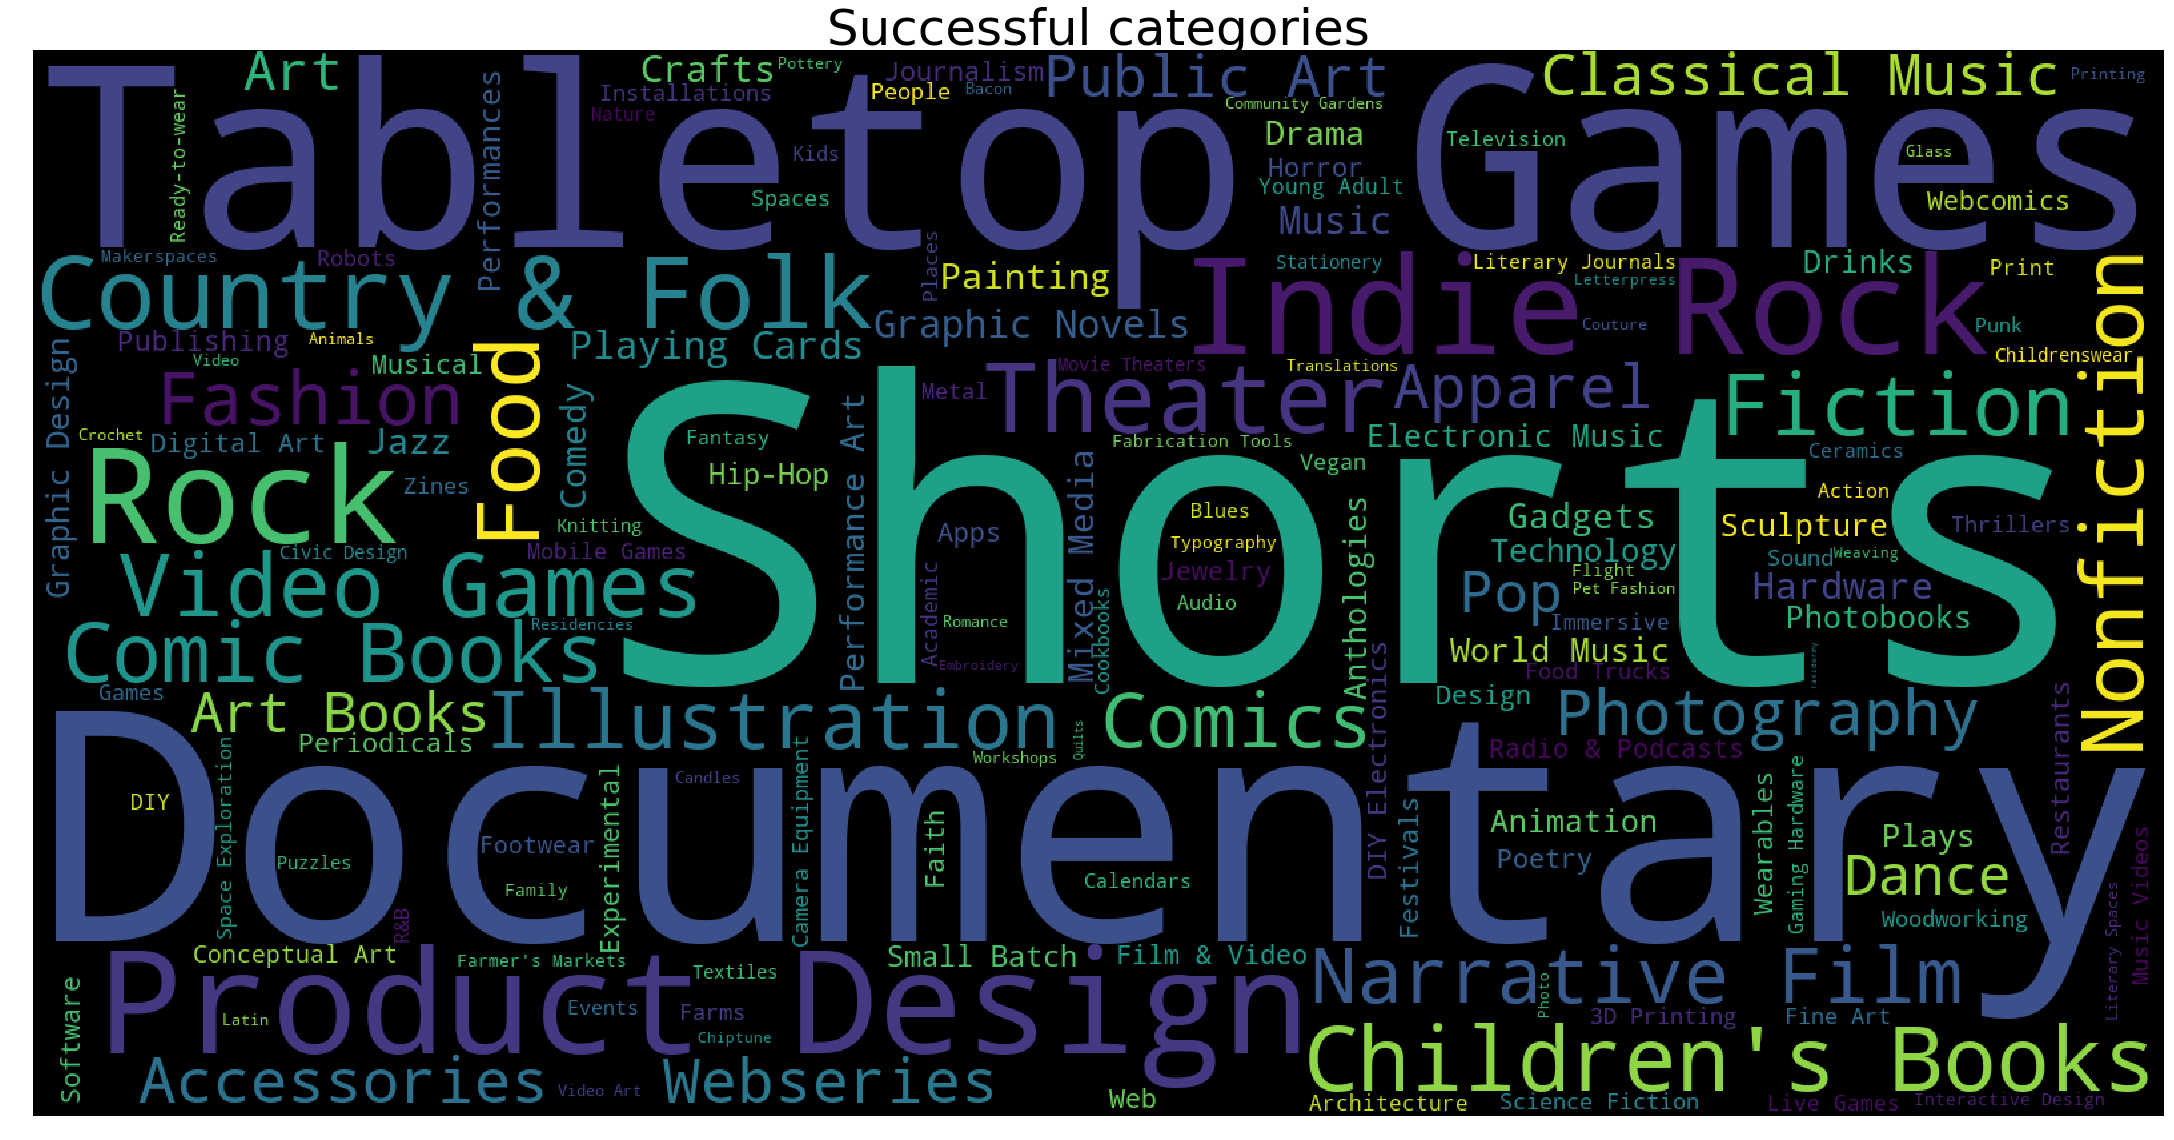

Time taken to run this cell : 0:00:01.847366


In [11]:
# Ploting word cloud
start = datetime.datetime.now()
# Lets first convert the 'result' dictionary to 'list of tuples'
# tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(freq_suc)
fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Successful categories', fontsize=50)
plt.show()
print("Time taken to run this cell :", datetime.datetime.now() - start)


In [12]:
fail_cat = data[data['state']=='failed']['cat_name'].values
freq_fail = Counter(fail_cat)

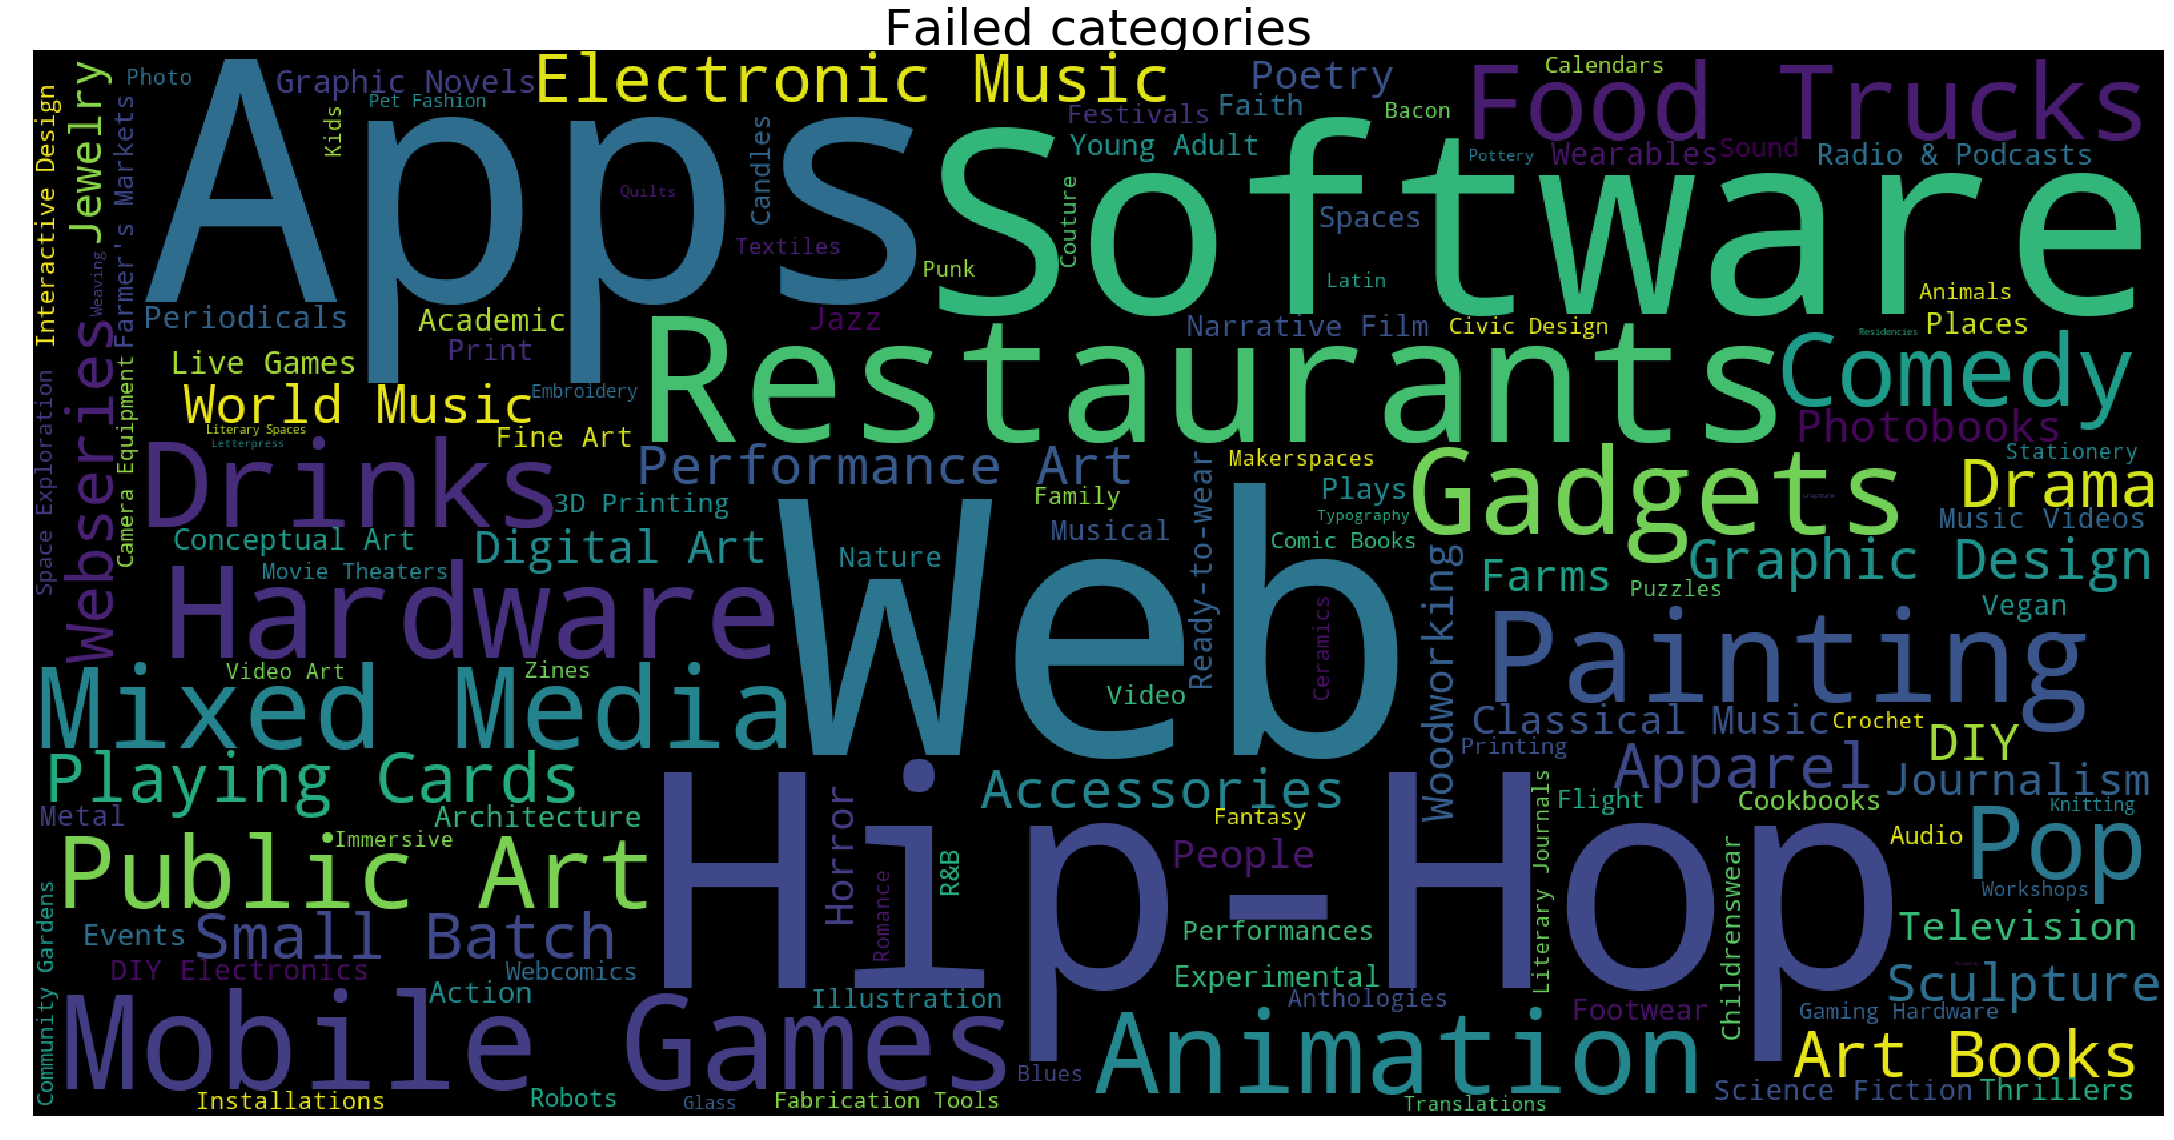

Time taken to run this cell : 0:00:01.790496


In [13]:
# Ploting word cloud
start = datetime.datetime.now()
# Lets first convert the 'result' dictionary to 'list of tuples'
# tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(freq_fail)
fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Failed categories', fontsize=50)
plt.show()
print("Time taken to run this cell :", datetime.datetime.now() - start)


## Basic Feature Extraction

In [14]:
data = data[['deadline', 'goal',
             'launched_at','staff_pick', 'loc_country', 'cat_name', 'cat_parent', 'blurb','state']]

In [15]:
data['launched_at'] = pd.to_datetime(data['launched_at'])
data['deadline'] = pd.to_datetime(data['deadline'])
data['campaign_length'] = (data['deadline'] - data['launched_at']).dt.days
data['blurb_length'] = data['blurb'].apply(lambda x: len(x.split()))

data.drop(columns=['launched_at','deadline'], inplace=True)

data = pd.get_dummies(data, columns=['loc_country','cat_name', 'cat_parent'])

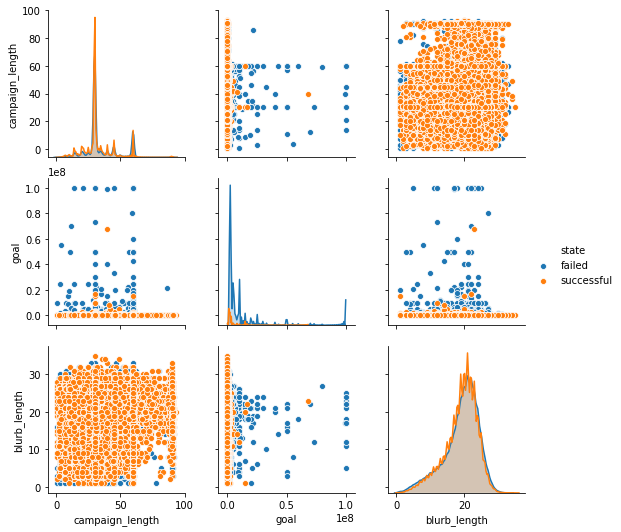

In [16]:
sns.pairplot(data, hue='state', vars=['campaign_length', 'goal', 'blurb_length'])

In [17]:
pd.crosstab(data['staff_pick'], data['state'])

state,failed,successful
staff_pick,,
False,85907,96092
True,2813,24182


In [18]:
data.head()

,goal,staff_pick,blurb,state,campaign_length,blurb_length,loc_country_AE,loc_country_AF,loc_country_AG,loc_country_AL,loc_country_AM,loc_country_AQ,loc_country_AR,loc_country_AT,loc_country_AU,loc_country_AX,loc_country_AZ,loc_country_BA,loc_country_BB,loc_country_BD,loc_country_BE,loc_country_BF,loc_country_BG,loc_country_BH,loc_country_BJ,loc_country_BM,loc_country_BO,loc_country_BR,loc_country_BS,loc_country_BT,loc_country_BW,loc_country_BY,loc_country_BZ,loc_country_CA,loc_country_CD,loc_country_CG,loc_country_CH,loc_country_CI,loc_country_CK,loc_country_CL,loc_country_CM,loc_country_CN,loc_country_CO,loc_country_CR,loc_country_CU,loc_country_CV,loc_country_CW,loc_country_CY,loc_country_CZ,loc_country_DE,loc_country_DJ,loc_country_DK,loc_country_DM,loc_country_DO,loc_country_DZ,loc_country_EC,loc_country_EE,loc_country_EG,loc_country_ES,loc_country_ET,loc_country_FI,loc_country_FJ,loc_country_FM,loc_country_FO,loc_country_FR,loc_country_GA,loc_country_GB,loc_country_GD,loc_country_GE,loc_country_GH,loc_country_GI,loc_country_GL,loc_country_GM,loc_country_GN,loc_country_GP,loc_country_GQ,loc_country_GR,loc_country_GT,loc_country_GU,loc_country_GY,loc_country_HK,loc_country_HN,loc_country_HR,loc_country_HT,loc_country_HU,loc_country_ID,loc_country_IE,loc_country_IL,loc_country_IN,loc_country_IQ,loc_country_IR,loc_country_IS,loc_country_IT,loc_country_JM,loc_country_JO,loc_country_JP,loc_country_KE,loc_country_KG,loc_country_KH,loc_country_KI,loc_country_KN,loc_country_KP,loc_country_KR,loc_country_KW,loc_country_KY,loc_country_KZ,loc_country_LA,loc_country_LB,loc_country_LC,loc_country_LK,loc_country_LR,loc_country_LS,loc_country_LT,loc_country_LU,loc_country_LV,loc_country_LY,loc_country_MA,loc_country_MC,loc_country_MD,loc_country_ME,loc_country_MG,loc_country_MK,loc_country_ML,loc_country_MM,loc_country_MN,loc_country_MO,loc_country_MQ,loc_country_MR,loc_country_MT,loc_country_MU,loc_country_MV,loc_country_MW,loc_country_MX,loc_country_MY,loc_country_MZ,loc_country_NC,loc_country_NE,loc_country_NG,loc_country_NI,loc_country_NL,loc_country_NO,loc_country_NP,loc_country_NZ,loc_country_PA,loc_country_PE,loc_country_PF,loc_country_PG,loc_country_PH,loc_country_PK,loc_country_PL,loc_country_PN,loc_country_PR,loc_country_PS,loc_country_PT,loc_country_PY,loc_country_QA,loc_country_RO,loc_country_RS,loc_country_RU,loc_country_RW,loc_country_SA,loc_country_SC,loc_country_SD,loc_country_SE,loc_country_SG,loc_country_SI,loc_country_SJ,loc_country_SK,loc_country_SL,loc_country_SN,loc_country_SO,loc_country_SR,loc_country_SS,loc_country_SV,loc_country_SX,loc_country_SY,loc_country_SZ,loc_country_TC,loc_country_TD,loc_country_TH,loc_country_TJ,loc_country_TL,loc_country_TN,loc_country_TO,loc_country_TR,loc_country_TT,loc_country_TW,loc_country_TZ,loc_country_UA,loc_country_UG,loc_country_US,loc_country_UY,loc_country_VA,loc_country_VC,loc_country_VE,loc_country_VI,loc_country_VN,loc_country_VU,loc_country_WS,loc_country_XK,loc_country_YE,loc_country_ZA,loc_country_ZM,loc_country_ZW,loc_country_nor-bel-air-md,loc_country_nta-clarita-ca,loc_country_short_name,loc_country_ub-hills-il,cat_name_3D Printing,cat_name_Academic,cat_name_Accessories,cat_name_Action,cat_name_Animals,cat_name_Animation,cat_name_Anthologies,cat_name_Apparel,cat_name_Apps,cat_name_Architecture,cat_name_Art,cat_name_Art Books,cat_name_Audio,cat_name_Bacon,cat_name_Blues,cat_name_Calendars,cat_name_Camera Equipment,cat_name_Candles,cat_name_Ceramics,cat_name_Children's Books,cat_name_Childrenswear,cat_name_Chiptune,cat_name_Civic Design,cat_name_Classical Music,cat_name_Comedy,cat_name_Comic Books,cat_name_Comics,cat_name_Community Gardens,cat_name_Conceptual Art,cat_name_Cookbooks,cat_name_Country & Folk,cat_name_Couture,cat_name_Crafts,cat_name_Crochet,cat_name_DIY,cat_name_DIY Electronics,cat_name_Dance,cat_name_Design,cat_name_Digital Art,cat_name_Documentary,cat_name_Drama,cat_name_Drinks,cat_name_Electronic Music,cat_name_Embroidery,cat_name_Events,cat_name_Expe

In [19]:
print(data.shape)

(208994, 382)


## Sample 100k rows 

In [20]:
data = data.sample(n=100000,random_state=42).reset_index()
data.shape
data.head()

,index,goal,staff_pick,blurb,state,campaign_length,blurb_length,loc_country_AE,loc_country_AF,loc_country_AG,loc_country_AL,loc_country_AM,loc_country_AQ,loc_country_AR,loc_country_AT,loc_country_AU,loc_country_AX,loc_country_AZ,loc_country_BA,loc_country_BB,loc_country_BD,loc_country_BE,loc_country_BF,loc_country_BG,loc_country_BH,loc_country_BJ,loc_country_BM,loc_country_BO,loc_country_BR,loc_country_BS,loc_country_BT,loc_country_BW,loc_country_BY,loc_country_BZ,loc_country_CA,loc_country_CD,loc_country_CG,loc_country_CH,loc_country_CI,loc_country_CK,loc_country_CL,loc_country_CM,loc_country_CN,loc_country_CO,loc_country_CR,loc_country_CU,loc_country_CV,loc_country_CW,loc_country_CY,loc_country_CZ,loc_country_DE,loc_country_DJ,loc_country_DK,loc_country_DM,loc_country_DO,loc_country_DZ,loc_country_EC,loc_country_EE,loc_country_EG,loc_country_ES,loc_country_ET,loc_country_FI,loc_country_FJ,loc_country_FM,loc_country_FO,loc_country_FR,loc_country_GA,loc_country_GB,loc_country_GD,loc_country_GE,loc_country_GH,loc_country_GI,loc_country_GL,loc_country_GM,loc_country_GN,loc_country_GP,loc_country_GQ,loc_country_GR,loc_country_GT,loc_country_GU,loc_country_GY,loc_country_HK,loc_country_HN,loc_country_HR,loc_country_HT,loc_country_HU,loc_country_ID,loc_country_IE,loc_country_IL,loc_country_IN,loc_country_IQ,loc_country_IR,loc_country_IS,loc_country_IT,loc_country_JM,loc_country_JO,loc_country_JP,loc_country_KE,loc_country_KG,loc_country_KH,loc_country_KI,loc_country_KN,loc_country_KP,loc_country_KR,loc_country_KW,loc_country_KY,loc_country_KZ,loc_country_LA,loc_country_LB,loc_country_LC,loc_country_LK,loc_country_LR,loc_country_LS,loc_country_LT,loc_country_LU,loc_country_LV,loc_country_LY,loc_country_MA,loc_country_MC,loc_country_MD,loc_country_ME,loc_country_MG,loc_country_MK,loc_country_ML,loc_country_MM,loc_country_MN,loc_country_MO,loc_country_MQ,loc_country_MR,loc_country_MT,loc_country_MU,loc_country_MV,loc_country_MW,loc_country_MX,loc_country_MY,loc_country_MZ,loc_country_NC,loc_country_NE,loc_country_NG,loc_country_NI,loc_country_NL,loc_country_NO,loc_country_NP,loc_country_NZ,loc_country_PA,loc_country_PE,loc_country_PF,loc_country_PG,loc_country_PH,loc_country_PK,loc_country_PL,loc_country_PN,loc_country_PR,loc_country_PS,loc_country_PT,loc_country_PY,loc_country_QA,loc_country_RO,loc_country_RS,loc_country_RU,loc_country_RW,loc_country_SA,loc_country_SC,loc_country_SD,loc_country_SE,loc_country_SG,loc_country_SI,loc_country_SJ,loc_country_SK,loc_country_SL,loc_country_SN,loc_country_SO,loc_country_SR,loc_country_SS,loc_country_SV,loc_country_SX,loc_country_SY,loc_country_SZ,loc_country_TC,loc_country_TD,loc_country_TH,loc_country_TJ,loc_country_TL,loc_country_TN,loc_country_TO,loc_country_TR,loc_country_TT,loc_country_TW,loc_country_TZ,loc_country_UA,loc_country_UG,loc_country_US,loc_country_UY,loc_country_VA,loc_country_VC,loc_country_VE,loc_country_VI,loc_country_VN,loc_country_VU,loc_country_WS,loc_country_XK,loc_country_YE,loc_country_ZA,loc_country_ZM,loc_country_ZW,loc_country_nor-bel-air-md,loc_country_nta-clarita-ca,loc_country_short_name,loc_country_ub-hills-il,cat_name_3D Printing,cat_name_Academic,cat_name_Accessories,cat_name_Action,cat_name_Animals,cat_name_Animation,cat_name_Anthologies,cat_name_Apparel,cat_name_Apps,cat_name_Architecture,cat_name_Art,cat_name_Art Books,cat_name_Audio,cat_name_Bacon,cat_name_Blues,cat_name_Calendars,cat_name_Camera Equipment,cat_name_Candles,cat_name_Ceramics,cat_name_Children's Books,cat_name_Childrenswear,cat_name_Chiptune,cat_name_Civic Design,cat_name_Classical Music,cat_name_Comedy,cat_name_Comic Books,cat_name_Comics,cat_name_Community Gardens,cat_name_Conceptual Art,cat_name_Cookbooks,cat_name_Country & Folk,cat_name_Couture,cat_name_Crafts,cat_name_Crochet,cat_name_DIY,cat_name_DIY Electronics,cat_name_Dance,cat_name_Design,cat_name_Digital Art,cat_name_Documentary,cat_name_Drama,cat_name_Drinks,cat_name_Electronic Music,cat_name_Embroidery,cat_name_Events,cat_nam

## Preprocess the project description

In [21]:
def preprocess(desc):
    
    # remove any urls
    cleanr = re.compile("(http|ftp|https):\/\/([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?")
    desc = re.sub(cleanr, ' ', desc)
    
    # remove HTML Tags
    cleanr = re.compile('<.*?>')
    desc = re.sub(cleanr, ' ', desc)
    
    # Decontract tedesct
    desc = str(desc).lower()
    desc = desc.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    desc = re.sub(r"([0-9]+)000000", r"\1m", desc)
    desc = re.sub(r"([0-9]+)000", r"\1k", desc)
    
    # Remove Punctuations
    cleanr = re.compile("[^a-zA-Z0-9]")
    desc = re.sub(cleanr, ' ', desc)
    
    return desc

In [22]:
data['blurb'] = data['blurb'].apply(preprocess)

## Convert text to word vectors

### Extract IDF

In [25]:
desc = list(data['blurb'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(desc)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

### Convert to word vectors

In [26]:
if not os.path.isfile('word_vecs.csv'):

    # en_vectors_web_lg, which includes over 1 million unique vectors.
    nlp = spacy.load('en_core_web_sm')

    vecs = []
    # https://github.com/noamraph/tqdm
    # tqdm is used to print the progress bar
    for desc in tqdm(list(data['blurb'])):
        doc = nlp(desc) 
        # 384 is the number of dimensions of vectors 
        mean_vec = np.zeros([len(doc), 384])
        for word in doc:
            # word2vec
            vec = word.vector
            # fetch df score
            try:
                idf = word2tfidf[str(word)]
            except:
                idf = 0
            # compute final vec
            mean_vec += vec * idf
        mean_vec = mean_vec.mean(axis=0)
        vecs.append(mean_vec)
    vec_df = pd.DataFrame(vecs)
    vec_df.to_csv('word_vecs.csv', index=False)

  0%|          | 0/100000 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (26,384) (96,) (26,384) 

In [20]:
final_data =  pd.concat([data, vec_df], axis=1)
final_data.drop(columns=['index','blurb'],inplace=True)
final_data.to_csv('final_data.csv',index=False)
final_data.shape

(100000, 765)

In [21]:
for col in final_data.columns:
    print(col)

goal
staff_pick
state
campaign_length
blurb_length
loc_country_AE
loc_country_AF
loc_country_AG
loc_country_AL
loc_country_AM
loc_country_AQ
loc_country_AR
loc_country_AT
loc_country_AU
loc_country_AX
loc_country_AZ
loc_country_BA
loc_country_BB
loc_country_BD
loc_country_BE
loc_country_BF
loc_country_BG
loc_country_BH
loc_country_BJ
loc_country_BM
loc_country_BO
loc_country_BR
loc_country_BS
loc_country_BT
loc_country_BW
loc_country_BY
loc_country_BZ
loc_country_CA
loc_country_CD
loc_country_CG
loc_country_CH
loc_country_CI
loc_country_CK
loc_country_CL
loc_country_CM
loc_country_CN
loc_country_CO
loc_country_CR
loc_country_CU
loc_country_CV
loc_country_CW
loc_country_CY
loc_country_CZ
loc_country_DE
loc_country_DJ
loc_country_DK
loc_country_DM
loc_country_DO
loc_country_DZ
loc_country_EC
loc_country_EE
loc_country_EG
loc_country_ES
loc_country_ET
loc_country_FI
loc_country_FJ
loc_country_FM
loc_country_FO
loc_country_FR
loc_country_GA
loc_country_GB
loc_country_GD
loc_country_GE
loc_

### Train-Test Split

In [2]:
final_data = pd.read_csv('final_data.csv')

In [3]:
y = final_data['state']
X = final_data.drop(columns=['state'])
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42, shuffle=True)

## XGBoost

In [4]:
from xgboost import XGBClassifier

clf = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=11, missing=-999, n_estimators=500, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1337, silent=1, subsample=0.8)

clf.fit(X_train, y_train, eval_metric='auc')
joblib.dump(clf, 'xgb_nlp.pkl') 

['xgb_nlp.pkl']


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.81596
\Micro f1-score on test data : 0.8159600000000001
\Micro AUC score on test data : 0.9051139539919606

              precision    recall  f1-score   support

      failed       0.77      0.82      0.79     10678
  successful       0.86      0.82      0.84     14322

   micro avg       0.82      0.82      0.82     25000
   macro avg       0.81      0.82      0.81     25000
weighted avg       0.82      0.82      0.82     25000





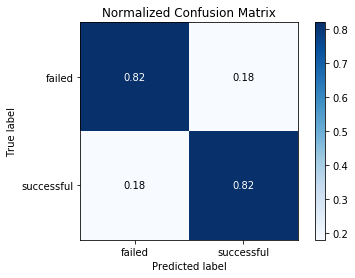

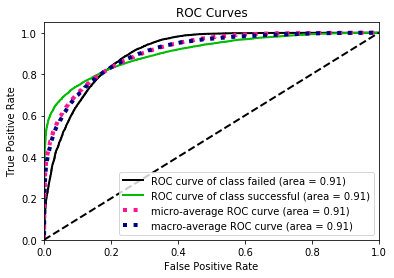

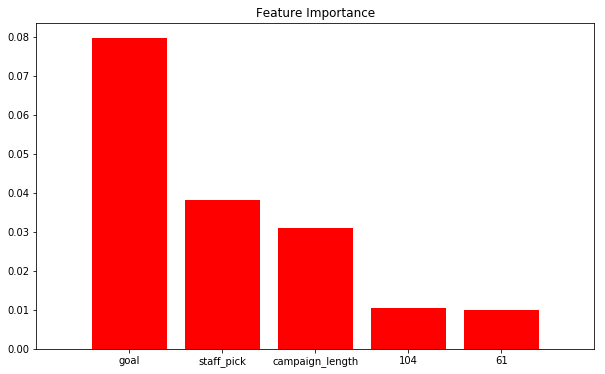

In [5]:
y_pred = clf.predict(X_test)
y_scores = clf.predict_proba(X_test)
print('\n########## CLASSIFICATION REPORTS ON TEST DATA ##########')
print('\n\taccuracy on test data : {}'.format(accuracy_score(y_test, y_pred)))
print('\Micro f1-score on test data : {}'.format(f1_score(y_test, y_pred, average='micro')))
print('\Micro AUC score on test data : {}'.format(roc_auc_score(y_test, y_scores[:,1], average='micro')))
print()
print(classification_report(y_test, y_pred))
print()
print()
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
skplt.metrics.plot_roc(y_test, y_scores)
skplt.estimators.plot_feature_importances(clf, feature_names=X_train.columns, max_num_features=5, figsize=(10,6))